In [1]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
data = pd.read_csv("D:\GIT\Amazon Review Sentimental\AmazonReview.csv")

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [30]:
data = data.dropna()

In [31]:
data.head()

,Review,Sentiment
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1
3,The cable was not compatible between my macboo...,1
4,The case is nice but did not have a glow light...,1


In [32]:
data['Sentiment'].value_counts()

1    5000
2    5000
3    5000
4    5000
5    4999
Name: Sentiment, dtype: int64

In [33]:
# If the sentiment is less than are equal to 3 it is a Negative one ohters are positive
data.loc[data['Sentiment']<=3,'Sentiment']=0
data.loc[data['Sentiment']>3,'Sentiment']=1

In [34]:
data['Sentiment'].value_counts()

0    15000
1     9999
Name: Sentiment, dtype: int64

In [39]:
# With Stemming, Stopwords and Lemmatization
def Stemming(data):
    corpus = []
    for i in data:
        sent = re.sub('[^a-zA-Z]',' ',i)
        sent = sent.lower()
        stem = PorterStemmer()
        #word tokenize
        words = nltk.word_tokenize(sent)
        words = [stem.stem(word) for word in words if word not in stopwords.words('english')]
        sent = ' '.join(words)
        corpus.append(sent)
    return corpus
def lemmatization(data):
    corpus=[]
    for i in data:
        sent = re.sub('[^a-zA-Z]',' ',i)
        sent = sent.lower()
        lem = WordNetLemmatizer()
        # Word Tokenization
        words = nltk.word_tokenize(sent)
        words = [lem.lemmatize(word) for word in words if word not in stopwords.words('english')]
        sent = ' '.join(words)
        corpus.append(sent)
    return corpus
def clean_data(data):
    data = re.sub('[^a-zA-Z]',' ',data)
    data = data.lower()
    sent = " ".join(word for word in data.split() if word not in stopwords.words('english'))
    return sent

In [47]:
def word_to_Vectorization(type_,data):
    if type_ == 'BOW':
        vector = CountVectorizer(ngram_range=(2,2),max_features=2500)
    else:
        vector = TfidfVectorizer(max_features=2500)
    return vector.fit_transform(data).toarray()

In [12]:
def run_all_models(xtrain,xtest,ytrain,ytest):
    lr = LogisticRegression()
    nb = MultinomialNB()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    xg = xgb.XGBClassifier()
    cat = CatBoostClassifier(silent=True)
    
    models = [lr,nb,dt,rf,xg,cat]
    model_name = ['Logistic Regression','Naive Bayes','Decision Tree Classifier','Random Forest Classifier','XG Boost Classifier','Cat Boost Classifier']
    t=0
    for i in range(len(models)):
        model = models[i]
        print('--'*10+model_name[i]+'--'*10)
        exec('i.fit(xtrain,ytrain)',{'xtrain':xtrain,'ytrain':ytrain,'i':model})
        predict=model.predict(xtest)
        e = exec('print(classification_report(ytest,predict))',{'xtest':xtest,'ytest':ytest,'predict':predict,'classification_report':classification_report})

        r = float("{:.2f}".format(accuracy_score(ytest,model.predict(xtest))))
        if r > t:
            t = r
            p,s = hyperparameter_tunning(model_name[i],xtrain,ytrain)
            output = 'Before Hyperparameter Tunning:\n'+ model_name[i]+" is having the Highest Performance with an Accuracy rate of "+str(r*100)+'%\n\n'+"After Hyperparameter Tunning:\n"+model_name[i]+" best parameters are "+str(p)+" is having the Highest Performance with an Accuracy rate of "+str(s*100)+'%'
    return output
        
    

In [13]:
def train_test(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=0)
    return run_all_models(X_train,X_test,y_train,y_test)

In [14]:
def hyperparameter_tunning(i,X_train,y_train):
    if i == 'Logistic Regression':
        parm = {'max_iter':np.arange(0,5000,500)}
        gv = GridSearchCV(LogisticRegression(),param_grid=parm,cv=10,scoring='accuracy')
        gv.fit(X_train,y_train)
        return gv.best_params_,gv.best_score_
    elif i == 'Decision Tree Classifier':
        params = {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_split': [5, 10, 20, 50, 100],
            'criterion': ['gini', 'entropy'],
        }
        grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=10, scoring='accuracy')
        grid_search.fit(X_train,y_train)
        return gv.best_params_,gv.best_score_
    elif i == 'Random Forest Classifier':
        parameters = {
            "n_estimators": [10, 50, 100, 200],
            "max_depth": [3, 5, 7, 10],
            "min_samples_split": [2, 5, 10, 20],
            "min_samples_leaf": [1, 2, 5, 10],
        }
        gscv = GridSearchCV(RandomForestClassifier, param_grid=parameters, scoring="accuracy", cv=10)
        gscv.fit(X_train,y_train)
        return gv.best_params_,gv.best_score_
    elif i == 'XG Boost Classifier':
        params = {
            "eta": [0.01, 0.03, 0.1, 0.3],
            "n_estimators": [100, 200, 300, 400],
            "max_depth": [3, 4, 5, 6],
            "subsample": [0.7, 0.8, 0.9],
            "gamma": [0, 0.001, 0.003, 0.01],
            "alpha": [0, 0.0001, 0.0003, 0.001],
        }
        grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid=params, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train,y_train)
        return gv.best_params_,gv.best_score_

In [40]:
data['Review']=data['Review'].apply(clean_data)

# Sentiment analysis Negative

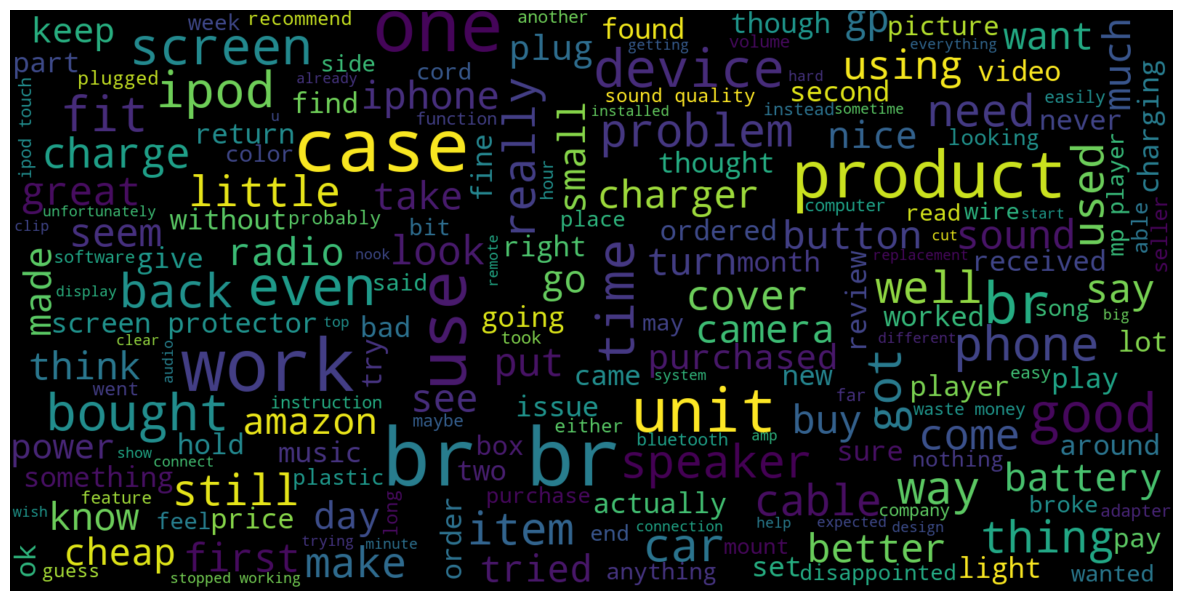

In [45]:
consolidated=' '.join(word for word in data['Review'][data['Sentiment']==0].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment analysis Positive

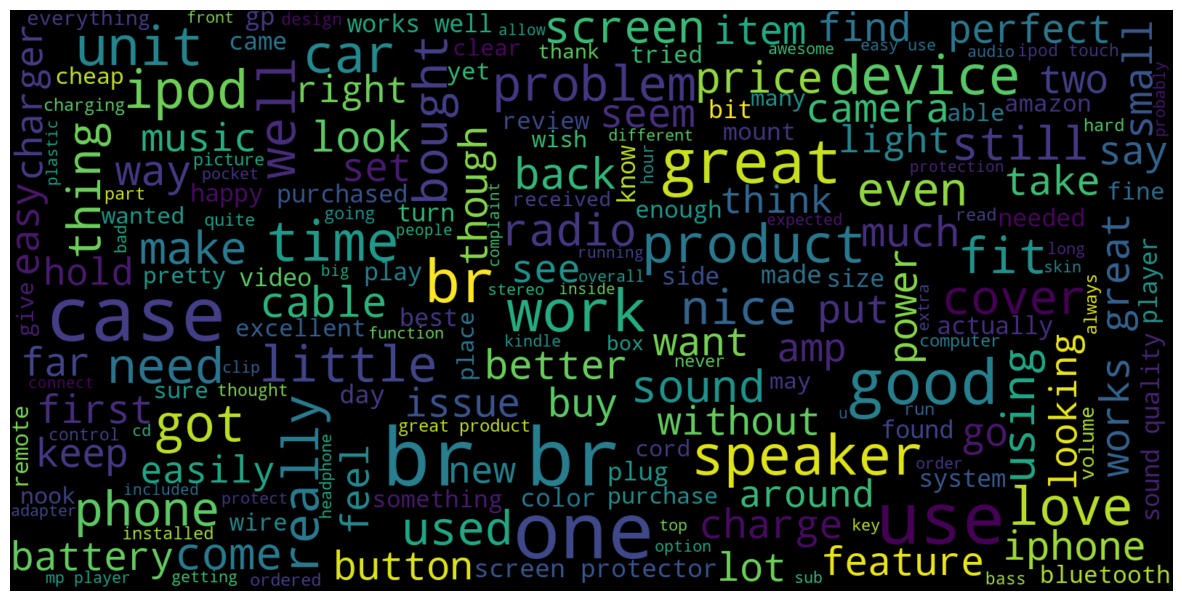

In [46]:
consolidated=' '.join(word for word in data['Review'][data['Sentiment']==1].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

# Using Bag Of Words

In [49]:
train_test(word_to_Vectorization('BOW',data['Review']),data['Sentiment'])

--------------------Logistic Regression--------------------
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      4513
           1       0.71      0.54      0.61      2987

    accuracy                           0.73      7500
   macro avg       0.72      0.70      0.70      7500
weighted avg       0.72      0.73      0.72      7500

--------------------Naive Bayes--------------------
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4513
           1       0.68      0.63      0.65      2987

    accuracy                           0.73      7500
   macro avg       0.72      0.71      0.72      7500
weighted avg       0.73      0.73      0.73      7500

--------------------Decision Tree Classifier--------------------
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      4513
           1       0.60      0.56      0.58      2987

    a

"Before Hyperparameter Tunning:\nLogistic Regression is having the Highest Performance with an Accuracy rate of 73.0%\n\nAfter Hyperparameter Tunning:\nLogistic Regression best parameters are {'max_iter': 500} is having the Highest Performance with an Accuracy rate of 72.53563669035368%"

# Using Tf-idf Vectorization

In [48]:
train_test(word_to_Vectorization('tfidf',data['Review']),data['Sentiment'])

--------------------Logistic Regression--------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4513
           1       0.80      0.70      0.75      2987

    accuracy                           0.81      7500
   macro avg       0.81      0.79      0.80      7500
weighted avg       0.81      0.81      0.81      7500

--------------------Naive Bayes--------------------
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      4513
           1       0.82      0.62      0.70      2987

    accuracy                           0.79      7500
   macro avg       0.80      0.76      0.77      7500
weighted avg       0.80      0.79      0.79      7500

--------------------Decision Tree Classifier--------------------
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      4513
           1       0.60      0.64      0.62      2987

    a

"Before Hyperparameter Tunning:\nLogistic Regression is having the Highest Performance with an Accuracy rate of 81.0%\n\nAfter Hyperparameter Tunning:\nLogistic Regression best parameters are {'max_iter': 500} is having the Highest Performance with an Accuracy rate of 81.34178224291432%"